<a href="https://colab.research.google.com/github/flybiubiu/cs231n/blob/master/BatchNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!git clone https://github.com/Halfish/cs231n.git
%cd cs231n/assignment2
!pip install imageio
%cd cs231n/datasets/
!/content/cs231n/assignment2/cs231n/datasets/get_datasets.sh
%cd '/content/cs231n/assignment2'

fatal: destination path 'cs231n' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'cs231n/assignment2'
/content/cs231n/assignment2
/content/cs231n/assignment2/cs231n/datasets
--2019-11-25 13:07:12--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2019-11-25 13:07:13 ERROR 500: Internal Server Error.

tar (child): cifar-10-python.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
rm: cannot remove 'cifar-10-python.tar.gz': No such file or directory
/content/cs231n/assignment2


In [18]:
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

def rel_error(x, y):#相对误差
  return np.max(np.abs(x - y) / np.maximum(1e-8, np.abs(x) + np.abs(y)))#maximum取两个钟较大的,1e-8为底线

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape 

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


In [20]:
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)#rand函数根据给定维度生成[0,1)之间的数据，包含0，不包含1
                          #randn函数返回一个或一组样本，具有标准正态分布。
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)
print 'Before batch normalization:'
print '  means: ', a.mean(axis=0)
print '  stds: ', a.std(axis=0)
#平均数应该接近0，标准差应该接近1
print 'After batch normalization (gamma=1, beta=0)'

Before batch normalization:
  means:  [ -7.01663268 -14.79923986   5.08412109]
  stds:  [28.58336484 26.90021327 25.94528637]
After batch normalization (gamma=1, beta=0)


In [0]:
def batchnorm_forward(x, gamma, beta, bn_param):
  mode = bn_param['mode']
  eps = bn_param.get('eps', 1e-5)
  momentum = bn_param.get('momentum', 0.9)
  N, D = x.shape
  running_mean = bn_param.get('running_mean', np.zeros(D, dtype = x.dtype))
  running_var = bn_param.get('running_var', np.zeros(D, dtype = x.dtype))

  out, cache = None, None
  if mode == 'train':
    sample_mean = np.mean(x, axis = 0)
    sample_var = np.var(x, axis = 0)
    x_hat = (x - sample_mean) / np.sqrt(sample_var + eps)
    out = gamma * x_hat + beta
    cache = (x, gamma, beta, x_hat, sample_mean, sample_var, eps)

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var
  elif mode == 'test':
    x_hat = (x - running_mean) / np.sqrt(running_var + eps)
    out = gamma * x_hat + beta
  bn_param['running_mean'] = running_mean
  bn_param['running_var'] = running_var
  return out, cache

In [22]:
print 'After batch normalization (gamma=1, beta=0)'
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print '  mean: ', a_norm.mean(axis=0)
print '  std: ', a_norm.std(axis=0)

After batch normalization (gamma=1, beta=0)
  mean:  [-9.43689571e-18 -3.06525638e-16  4.38538095e-17]
  std:  [0.99999999 0.99999999 0.99999999]


In [23]:
gamma = np.asarray([1.0, 2.0, 3.0])#array和asarray都可以将结构数据转化为ndarray，
#但是主要区别就是当数据源是ndarray时，array仍然会copy出一个副本，占用新的内存，但asarray不会
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print 'After batch normalization (nontrivial gamma, beta)'
print '  means: ', a_norm.mean(axis=0)
print '  stds: ', a_norm.std(axis=0)

After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999998]


In [24]:
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in xrange(50):#xrange() 函数用法与 range 完全相同，所不同的是生成的不是一个数组，而是一个生成器。
#list(xrange(8)) ----> [0,1,2,3,4,5,6,7]
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print 'After batch normalization (test-time):'
print '  means: ', a_norm.mean(axis=0)
print '  stds: ', a_norm.std(axis=0)

After batch normalization (test-time):
  means:  [-0.00419561  0.12486806 -0.07660708]
  stds:  [1.02192348 0.94842391 0.95688307]


In [0]:
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]
dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

In [0]:
def batchnorm_backward(dout, cache):
  dx, dgamma, dbeta = None, None, None
  x, gamma, beta, x_hat, sample_mean, sample_var, eps = cache
  dbeta = np.sum(dout, axis=0)
  dgamma = np.sum(x_hat *  dout, axis=0)

  N = x.shape[0]
  dx_norm = dout * gamma
  dx_sub_mean_1 = dx_norm / (np.sqrt(sample_var + eps))
  d1_sqrt_v = np.sum(dx_norm * (x - sample_mean), axis=0)
  dsqrt_v = - d1_sqrt_v / (sample_var + eps)
  dv = 0.5 * dsqrt_v / np.sqrt(sample_var + eps)
  dx_square = np.ones_like(x) / N * dv
  dx_sub_mean_2 = dx_square * (x - sample_mean) * 2
  dx_sub_mean = dx_sub_mean_1 + dx_sub_mean_2
  dx = dx_sub_mean + np.ones_like(x) / N * np.sum(-dx_sub_mean, axis=0)
  return dx, dgamma, dbeta

In [30]:
_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print 'dx error: ', rel_error(dx_num, dx)
print 'dgamma error: ', rel_error(da_num, dgamma)
print 'dbeta error: ', rel_error(db_num, dbeta)

dx error:  8.479880472958138e-09
dgamma error:  9.782108809452546e-11
dbeta error:  3.275620640788099e-12


In [0]:
def batchnorm_backward_alt(dout, cache):
  dx, dgamma, dbeta = None, None, None
  x, gamma, beta, x_hat, sample_mean, sample_var, eps = cache
  m = dout.shape[0] # m is N here
  dxhat = dout * gamma # (N, D)
  dvar = (dxhat * (x-sample_mean) * (-0.5) * np.power(sample_var+eps, -1.5)).sum(axis = 0)  # (D,)
  dmean = np.sum(dxhat * (-1) * np.power(sample_var + eps, -0.5), axis = 0)
  dmean += dvar * np.sum(-2 * (x - sample_mean), axis = 0) / m
  dx = dxhat * np.power(sample_var + eps, -0.5) + dvar*2*(x - sample_mean) / m + dmean / m
  dgamma = np.sum(dout * x_hat, axis = 0)
  dbeta = np.sum(dout, axis = 0)
  return dx, dgamma, dbeta

In [32]:
t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print 'dx difference: ', rel_error(dx1, dx2)
print 'dgamma difference: ', rel_error(dgamma1, dgamma2)
print 'dbeta difference: ', rel_error(dbeta1, dbeta2)
print 'speedup: %.2fx' % ((t2 - t1) / (t3 - t2))

dx difference:  3.624707520689513e-15
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.26x


In [33]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))#[0, low)
for reg in [0, 3.14]:
  print 'Running check with reg = ', reg
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)
  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))
  if reg == 0: print

Running check with reg =  0
Initial loss:  1.3028608316209245
W1 relative error: 2.17e-05
W2 relative error: 3.11e-04
W3 relative error: 2.90e-05
b1 relative error: 3.33e-03
b2 relative error: 2.22e-03
b3 relative error: 6.62e-08
beta1 relative error: 3.81e-09
beta2 relative error: 3.24e-08
gamma1 relative error: 4.13e-09
gamma2 relative error: 6.19e-08

Running check with reg =  3.14
Initial loss:  454.2604367546365
W1 relative error: 2.15e-05
W2 relative error: 5.52e-06
W3 relative error: 4.20e-07
b1 relative error: 2.22e-08
b2 relative error: 7.11e-07
b3 relative error: 1.34e-05
beta1 relative error: 9.09e-08
beta2 relative error: 1.48e-07
gamma1 relative error: 4.21e-08
gamma2 relative error: 3.42e-08


In [36]:
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration 1 / 200) loss: 13.114642
(Epoch 0 / 10) train acc: 0.134000; val_acc: 0.125000
(Epoch 1 / 10) train acc: 0.216000; val_acc: 0.178000
(Epoch 2 / 10) train acc: 0.224000; val_acc: 0.184000
(Epoch 3 / 10) train acc: 0.267000; val_acc: 0.202000
(Epoch 4 / 10) train acc: 0.308000; val_acc: 0.220000
(Epoch 5 / 10) train acc: 0.339000; val_acc: 0.219000
(Epoch 6 / 10) train acc: 0.374000; val_acc: 0.250000
(Epoch 7 / 10) train acc: 0.366000; val_acc: 0.265000
(Epoch 8 / 10) train acc: 0.407000; val_acc: 0.261000
(Epoch 9 / 10) train acc: 0.412000; val_acc: 0.259000
(Epoch 10 / 10) train acc: 0.444000; val_acc: 0.273000
(Iteration 1 / 200) loss: 2.641815
(Epoch 0 / 10) train acc: 0.066000; val_acc: 0.082000
(Epoch 1 / 10) train acc: 0.180000; val_acc: 0.156000
(Epoch 2 / 10) train acc: 0.212000; val_acc: 0.208000
(Epoch 3 / 10) train acc: 0.281000; val_acc: 0.227000
(Epoch 4 / 10) train acc: 0.316000; val_acc: 0.228000
(Epoch 5 / 10) train acc: 0.318000; val_acc: 0.249000
(Epoch 6 /

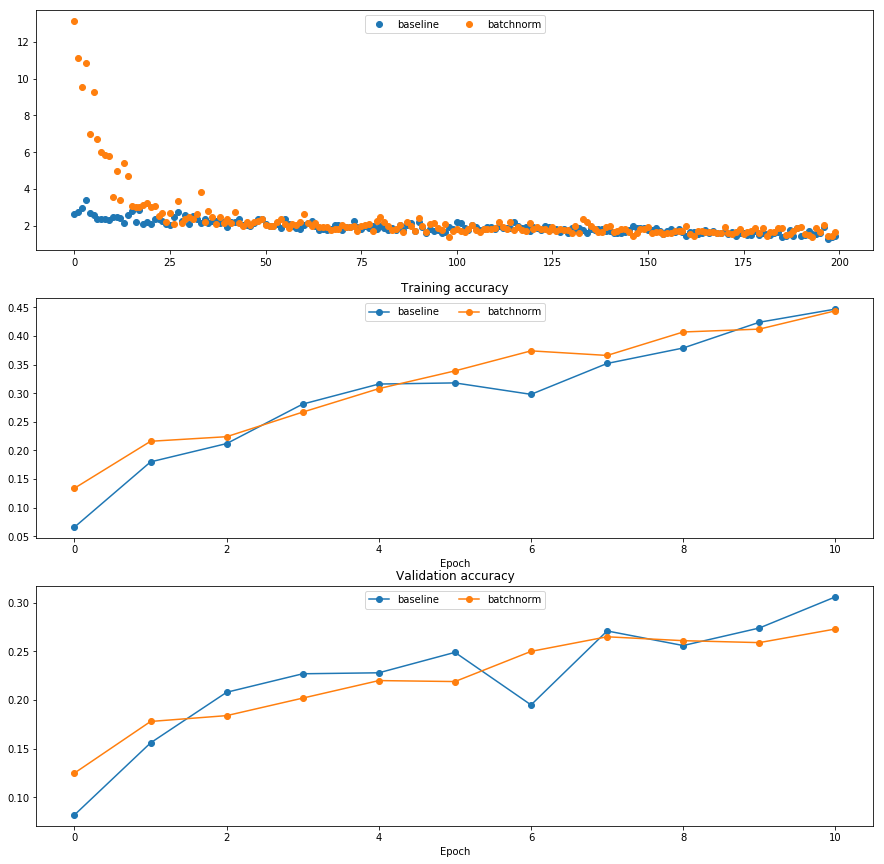

In [37]:
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label='baseline')
plt.plot(bn_solver.loss_history, 'o', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

In [38]:
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)#等比数列  -4开始 0 结束  一共20个
for i, weight_scale in enumerate(weight_scales):
  print 'Running weight scale %d / %d' % (i + 1, len(weight_scales))
  bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
  model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

  bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  bn_solver.train()
  bn_solvers[weight_scale] = bn_solver

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  solver.train()
  solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20


cs231n/layers.py:678: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


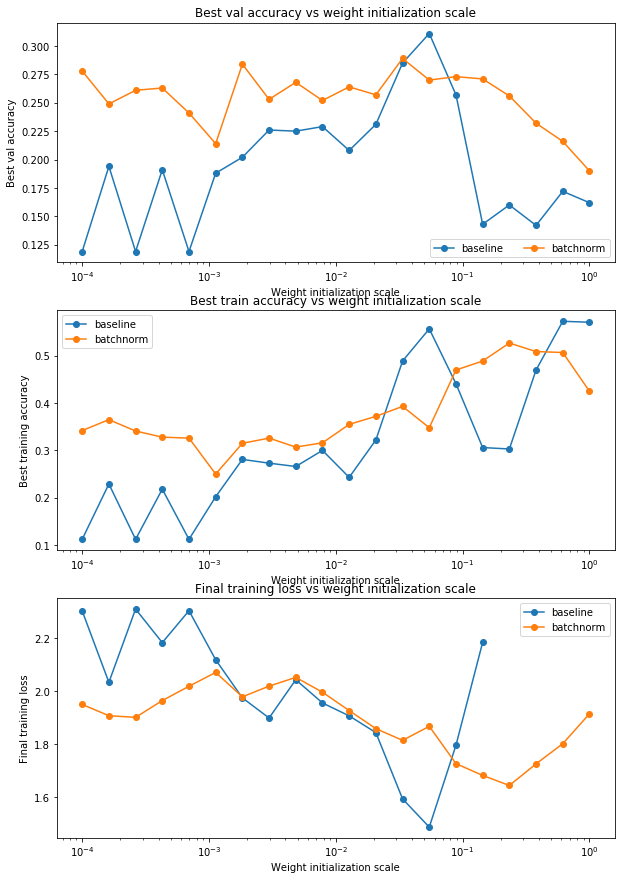

In [39]:
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))
  
  best_val_accs.append(max(solvers[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()